In [1]:
# Required imports
import torch
import torchaudio
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
# Load the Whisper model and processor
model_name = "openai/whisper-base"
processor = WhisperProcessor.from_pretrained(model_name)
model = WhisperForConditionalGeneration.from_pretrained(model_name)

In [3]:
# Load the MINDS-14 dataset
dataset = load_dataset("PolyAI/minds14", "en-US")

C:\Users\rohad\anaconda3\envs\cuda_test\Lib\site-packages\datasets\load.py:1454: FutureWarning: The repository for PolyAI/minds14 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/PolyAI/minds14
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [4]:
# Preprocess audio to 16kHz and convert to waveform
def preprocess_audio(audio):
    waveform, sample_rate = torchaudio.load(audio['path'])
    if sample_rate != 16000:
        waveform = torchaudio.transforms.Resample(sample_rate, 16000)(waveform)
    return waveform.squeeze().numpy()

In [5]:
# Tokenize input and predict transcription
def transcribe_audio(audio):
    input_features = processor(preprocess_audio(audio), return_tensors="pt", sampling_rate=16000).input_features
    predicted_ids = model.generate(input_features)
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription

In [6]:
# Example usage: transcribe the first audio file in the dataset
sample_audio = dataset['train'][0]['audio']

In [7]:
# Resample the audio to 16000 Hz
resampled_audio = librosa.resample(sample_audio['array'], orig_sr=sample_audio['sampling_rate'], target_sr=16000)

In [8]:
# Process the audio
input_features = processor(resampled_audio, sampling_rate=16000, return_tensors="pt").input_features

In [9]:
# Perform transcription (forcing language to English if needed)
forced_language = "en"  # set this to force transcription in English
transcription_ids = model.generate(input_features, forced_decoder_ids=processor.get_decoder_prompt_ids(language=forced_language, task="transcribe"))

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [10]:
# Decode the transcription
transcription = processor.batch_decode(transcription_ids, skip_special_tokens=True)[0]
print(f"Transcription: {transcription}")

Transcription:  I would like to set up a joint account with my partner. How do I proceed with doing that?


In [11]:
# --- Splitting the Dataset into Train and Test ---
# Convert dataset to DataFrame for easy handling
df = pd.DataFrame(dataset['train'])

In [12]:
# Split the dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Training Set Size: {len(train_df)}")
print(f"Testing Set Size: {len(test_df)}")

Training Set Size: 450
Testing Set Size: 113


In [13]:
# --- Visualizing Audio Data ---
def visualize_audio(audio_array, sampling_rate, title="Audio Waveform and Spectrogram"):
    # Plot waveplot
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(audio_array, sr=sampling_rate)
    plt.title(f"{title} - Waveplot")
    plt.show()

    # Plot spectrogram
    X = librosa.stft(audio_array)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"{title} - Spectrogram")
    plt.show()

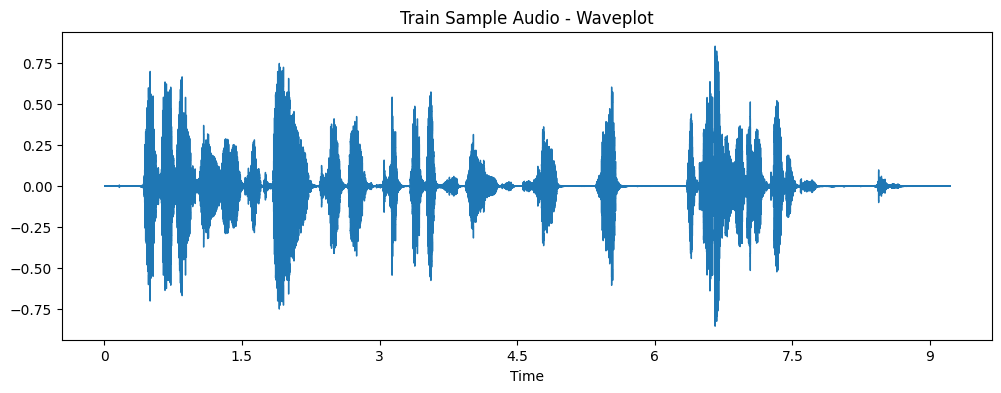

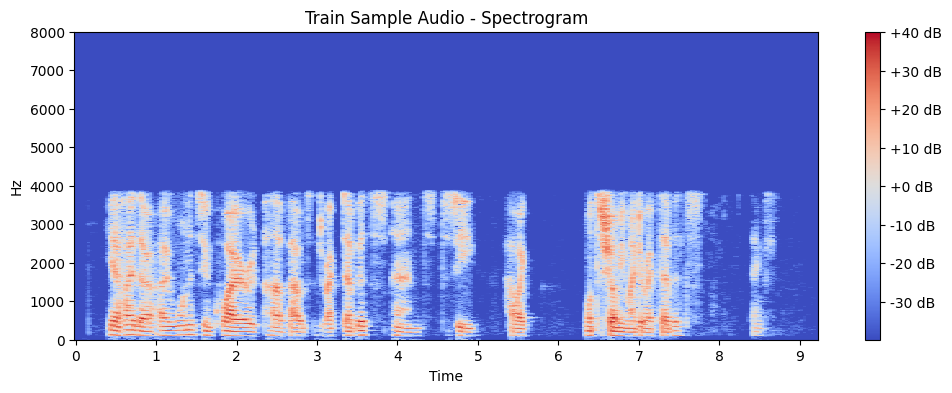

In [14]:
# Example visualization with the first audio from train_df
sample_audio = train_df.iloc[0]['audio']
resampled_audio = librosa.resample(sample_audio['array'], orig_sr=sample_audio['sampling_rate'], target_sr=16000)
visualize_audio(resampled_audio, 16000, title="Train Sample Audio")

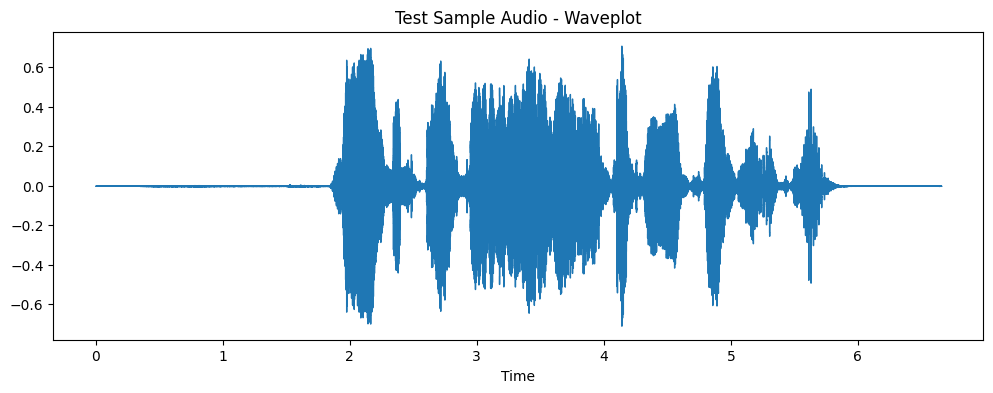

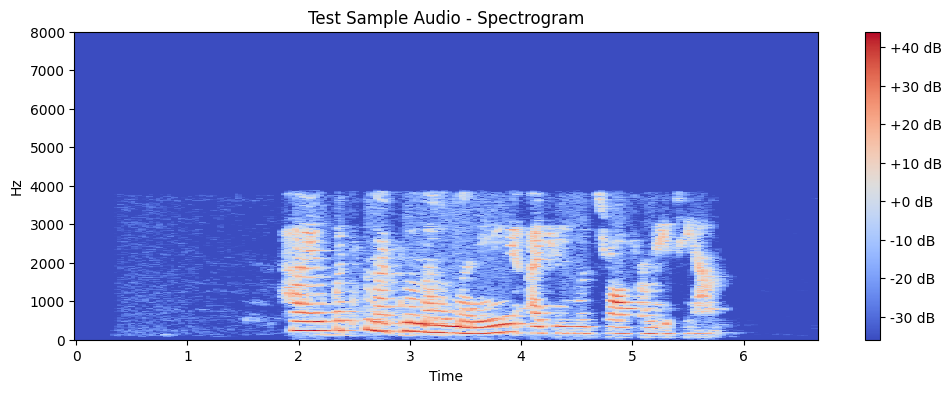

In [15]:
# Example visualization with the first audio from test_df
sample_audio = test_df.iloc[0]['audio']
resampled_audio = librosa.resample(sample_audio['array'], orig_sr=sample_audio['sampling_rate'], target_sr=16000)
visualize_audio(resampled_audio, 16000, title="Test Sample Audio")

In [16]:
# --- Evaluating Model Performance ---
y_true = []
y_pred = []

In [30]:
def evaluate_model(test_df, processor, model, correct_label_column='transcription', forced_language='en'):
    y_true = []
    y_pred = []

    for i in range(len(test_df)):
        sample_audio = test_df.iloc[i]['audio']
        
        # Akses label yang benar
        true_label = test_df.iloc[i][correct_label_column]  
        
        # Resample dan proses audio
        resampled_audio = librosa.resample(sample_audio['array'], orig_sr=sample_audio['sampling_rate'], target_sr=16000)
        input_features = processor(resampled_audio, sampling_rate=16000, return_tensors="pt").input_features
        
        # Lakukan transkripsi
        transcription_ids = model.generate(input_features, forced_decoder_ids=processor.get_decoder_prompt_ids(language=forced_language, task="transcribe"))
        transcription = processor.batch_decode(transcription_ids, skip_special_tokens=True)[0]
        
        # Tambahkan ke list
        y_true.append(true_label)
        y_pred.append(transcription)
    
    return y_true, y_pred

In [31]:
y_true, y_pred = evaluate_model(test_df, processor, model)

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Menghitung dan mencetak akurasi
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

# Mencetak laporan klasifikasi
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Mencetak confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Accuracy: 0.0
Classification Report:
                                                                                                                                                                                                                                                                                                                                                                                                 precision    recall  f1-score   support

                                                                                                                                                                                                                                                                                                                                                                       Account Balance, please.       0.00      0.00      0.00       0.0
                                                                                                                

C:\Users\rohad\anaconda3\envs\cuda_test\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rohad\anaconda3\envs\cuda_test\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rohad\anaconda3\envs\cuda_test\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [35]:
# Pastikan y_true dan y_pred telah dihasilkan oleh evaluate_model
y_true, y_pred = evaluate_model(test_df, processor, model)

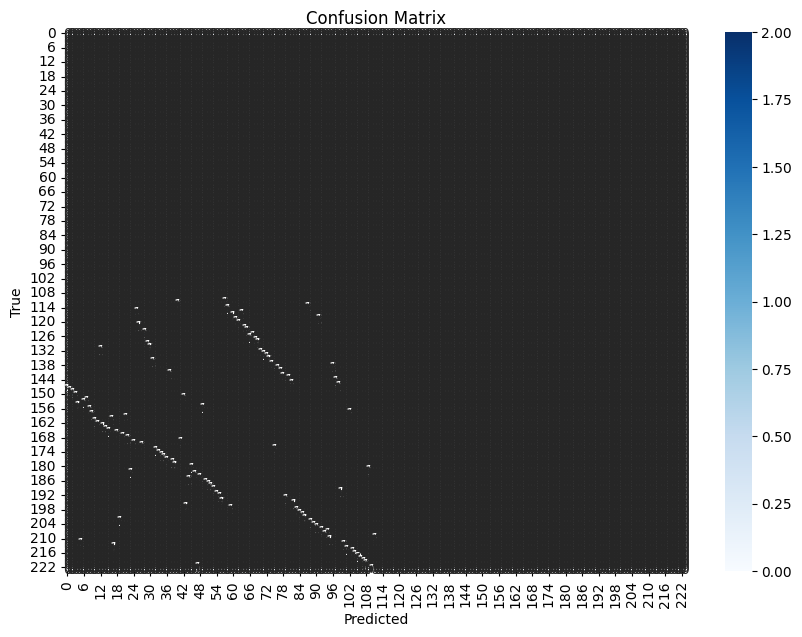

In [36]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [38]:
# Optional: Print accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.00
